In [1]:
%load_ext watermark
%watermark -u -n -t -z -v -p numpy,scipy,neupy,scikit-learn,matplotlib

Last updated: Sun Dec 18 2016 21:38:41 EET

CPython 3.4.3
IPython 5.1.0

numpy 1.11.2
scipy 0.18.1
neupy 0.4.0
scikit-learn 0.18
matplotlib 1.5.3


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [4]:
from sklearn import datasets, preprocessing, model_selection

dataset = datasets.load_digits()
target_scaler = preprocessing.OneHotEncoder()

transformed_input = (dataset.data / 16) - 0.5
target = dataset.target.reshape(-1, 1)
transformed_target = target_scaler.fit_transform(target)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    transformed_input,
    transformed_target.todense(),
    train_size=0.5,
    random_state=0,
)

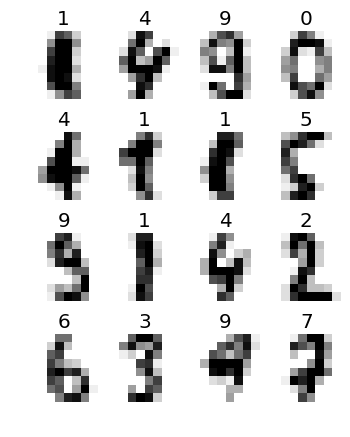

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(4, 5))

for i in range(16):
    image_coords = (i // 4, i % 4)
    image_axes = axes[image_coords]

    image_matrix = x_train[i, :].reshape((8, 8))
    image_name = y_train[i].argmax()

    image_axes.set_title(image_name)
    image_axes.imshow(
        image_matrix,
        cmap=plt.cm.binary,
        interpolation='nearest'
    )

    image_axes.axis('off')

In [6]:
import time
from sklearn import metrics
from neupy import algorithms, layers, environment

environment.reproducible()
environment.speedup()

net = algorithms.RPROP(
    [
        layers.Input(64),
        layers.Tanh(100),
        layers.Softmax(10),
    ],

    step=0.1,
    verbose=True,
    show_epoch='4 times',
    error='categorical_crossentropy',
    shuffle_data=True,
    
    decay_rate=0.01,
    addons=[algorithms.WeightDecay]
)


t0 = time.time()
net.train(x_train, y_train, x_test, y_test, epochs=100)
print("Total train time: {:.2f} sec".format(time.time() - t0))

y_predicted = net.predict(x_test).argmax(axis=1)
accuracy = metrics.accuracy_score(y_predicted, y_test.argmax(axis=1))

print("Validation data sample accuracy: {:.2%}".format(accuracy))

Couldn't import dot_parser, loading of dot files will not be possible.

Main information

[ALGORITHM] RPROP

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 4 times
[OPTION] shuffle_data = True
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = categorical_crossentropy
[OPTION] addons = ['WeightDecay']
[OPTION] decrease_factor = 0.5
[OPTION] increase_factor = 1.2
[OPTION] maxstep = 50
[OPTION] minstep = 0.1
[OPTION] decay_rate = 0.01

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 1.90 seconds

Start training

[TRAIN DATA] 898 samples, feature shape: (64,)
[TEST DATA] 899 samples, feature shape: (64,)
[TRAINING] Total epochs: 100

------------------------------------------------
| Epoch # | Train err | Valid err | Time       |
------------------------------------------------
| 1       | 2.27      | 2.774     | 6 ms       |
| 25      | 1.139     | 0.8849    | 6 ms       |
| 50

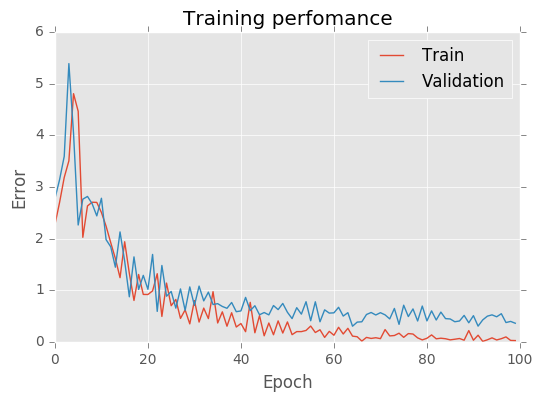

In [7]:
from neupy import plots
plots.error_plot(net);

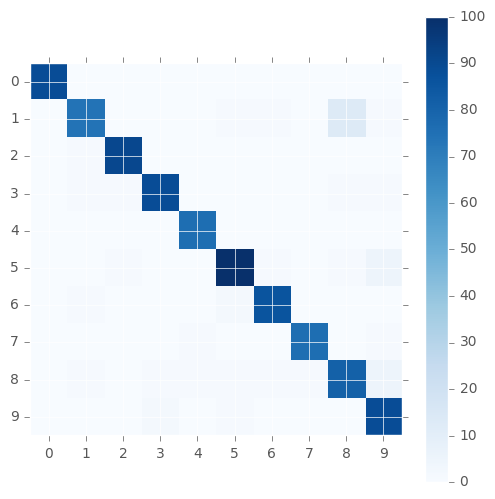

In [8]:
from sklearn import metrics

y_test_vector = y_test.argmax(axis=1)
y_test_vector = np.asarray(y_test_vector).reshape(y_test_vector.size)
confusion_matrix = metrics.confusion_matrix(y_test_vector, y_predicted)

plt.figure(figsize=(6, 6))
possible_classes = np.arange(10)

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()

plt.xticks(possible_classes, possible_classes)
plt.yticks(possible_classes, possible_classes)

plt.show()

(0, 64)

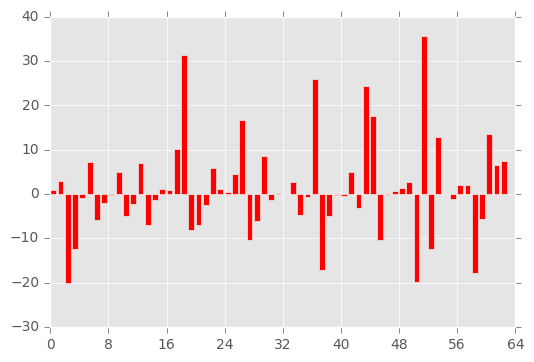

In [9]:
layers = list(net.connection)
hidden_layer = layers[1]
input_weights = hidden_layer.weight.get_value()

n_features = input_weights.shape[0]
feature_index = np.arange(n_features)

plt.bar(feature_index, input_weights.sum(axis=1), color='r')
plt.xticks(np.arange(0, 65, 8), np.arange(0, 65, 8))
plt.xlim(0, 64) 

(0, 64)

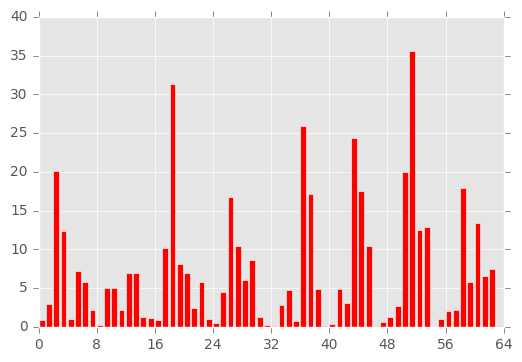

In [10]:
plt.bar(feature_index, np.abs(input_weights.sum(axis=1)), color='r')
plt.xticks(np.arange(0, 65, 8), np.arange(0, 65, 8))
plt.xlim(0, 64) 

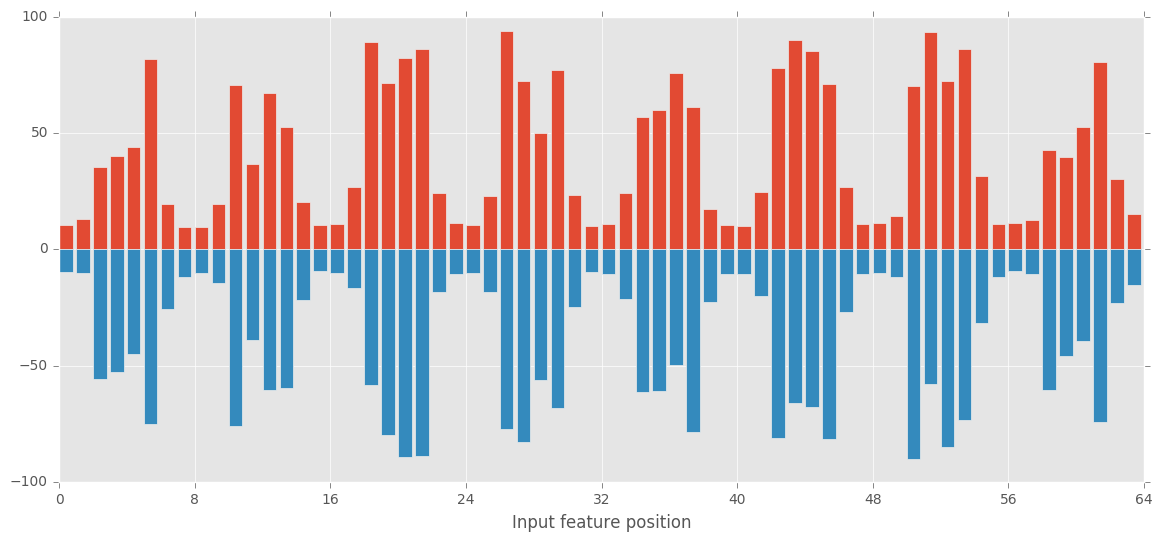

In [11]:
def feature_contribution(network):
    colors = plt.rcParams['axes.color_cycle']

    layers = list(network.connection)
    layer = layers[1]
        
    weights = layer.weight.get_value()
    n_features = network.connection.input_shape[0]
    feature_index = np.arange(n_features)

    positive_weights = np.where(weights > 0, weights, 0)
    
    plt.bar(feature_index, positive_weights.sum(axis=1),
            color=colors[0])

    negative_weights = np.where(weights < 0, weights, 0)
    plt.bar(feature_index, negative_weights.sum(axis=1),
            color=colors[1])

    plt.xlabel("Input feature position")
    plt.xlim(0, n_features)

plt.figure(figsize=(14, 6))
label_frequency = np.arange(0, n_features + 1, 8)
plt.xticks(label_frequency, label_frequency)

feature_contribution(net)

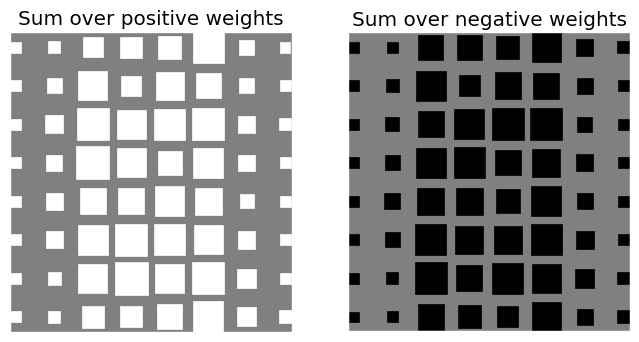

In [12]:
weights = layers[1].weight.get_value()
positive_weights = np.where(weights > 0, weights, 0)
negative_weights = np.where(weights < 0, weights, 0)

fig, (axes_left, axes_right) = plt.subplots(1, 2, figsize=(8, 12))

axes_left.set_title("Sum over positive weights")
plots.hinton(
    positive_weights.sum(axis=1).reshape((8, 8)),
    ax=axes_left,
    add_legend=False
)

axes_right.set_title("Sum over negative weights")
plots.hinton(
    negative_weights.sum(axis=1).reshape((8, 8)),
    ax=axes_right,
    add_legend=False
)
plt.show()

In [13]:
import six

def generate_layer_names(n_layers):
    if n_layers < 2:
        raise ValueError("Number of layers should be greater or "
                         "equal to 2")
        
    if not isinstance(n_layers, six.integer_types):
        raise ValueError("Number of layers should be an integer "
                         "number")

    patterns = {
        2: ['Input layer', 'Output layer'],
        3: ['Input layer', 'Hidden layer', 'Output layer'],
    } 

    if n_layers in patterns:
        return patterns[n_layers]
    
    layers_names = patterns[2]
    for i in range(1, n_layers - 1):
        layers_names.insert(-1, 'Hidden layer #{}'.format(i))

    return layers_names

print(generate_layer_names(n_layers=2))
print(generate_layer_names(n_layers=3))
print(generate_layer_names(n_layers=4))
print(generate_layer_names(n_layers=5)) 

['Input layer', 'Output layer']
['Input layer', 'Hidden layer', 'Output layer']
['Input layer', 'Hidden layer #1', 'Hidden layer #2', 'Output layer']
['Input layer', 'Hidden layer #1', 'Hidden layer #2', 'Hidden layer #3', 'Output layer']


In [14]:
def connection_threads(network, stretch=False):
    colors = plt.rcParams['axes.color_cycle']
    
    layers = list(network.connection)
    layers = layers[1:]  # ignore the Input layer

    layer_sizes = np.array([layer.output_shape[0] for layer in network.connection])
    max_n_inputs = float(layer_sizes.max())
    layer_shifts = (max_n_inputs - layer_sizes) / 2
    layers_iter = zip(layers, layer_shifts, layer_shifts[1:])

    for i, (layer, left_shift, right_shift) in enumerate(layers_iter):
        weight = layer.weight.get_value()
        max_value = np.abs(weight).max()

        layer_input_size, layer_output_size = weight.shape
        left_scaler = max_n_inputs / max(layer_input_size - 2, 2)
        right_scaler = max_n_inputs / max(layer_output_size - 1, 2)

        for (left_index, right_index), value in np.ndenumerate(weight):
            color = (colors[0] if np.sign(value) == 1 else colors[1])

            if stretch:
                y_coords = [(left_index) * left_scaler,
                            (right_index) * right_scaler]
            else:
                left_index += left_shift
                right_index += right_shift
                y_coords = [left_index, right_index]

            line = plt.plot([i, i + 1], y_coords, color,
                            alpha=abs(value) / (max_value))

    plt.ylim(-1, max_n_inputs + 1)

    n_layers = len(network.layers)
    plt.yticks([], [])
    plt.xticks(np.arange(n_layers), generate_layer_names(n_layers))

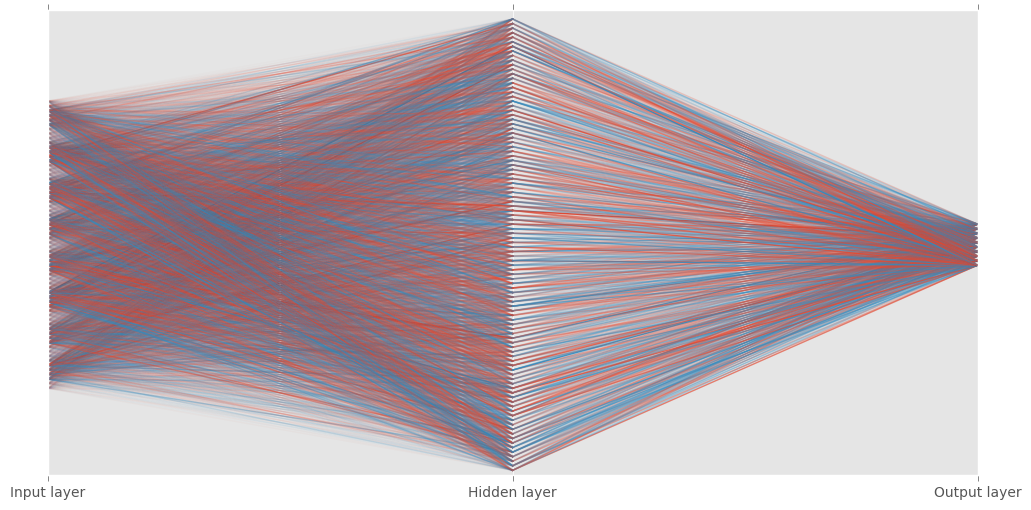

In [15]:
plt.figure(figsize=(12, 6))
connection_threads(net)

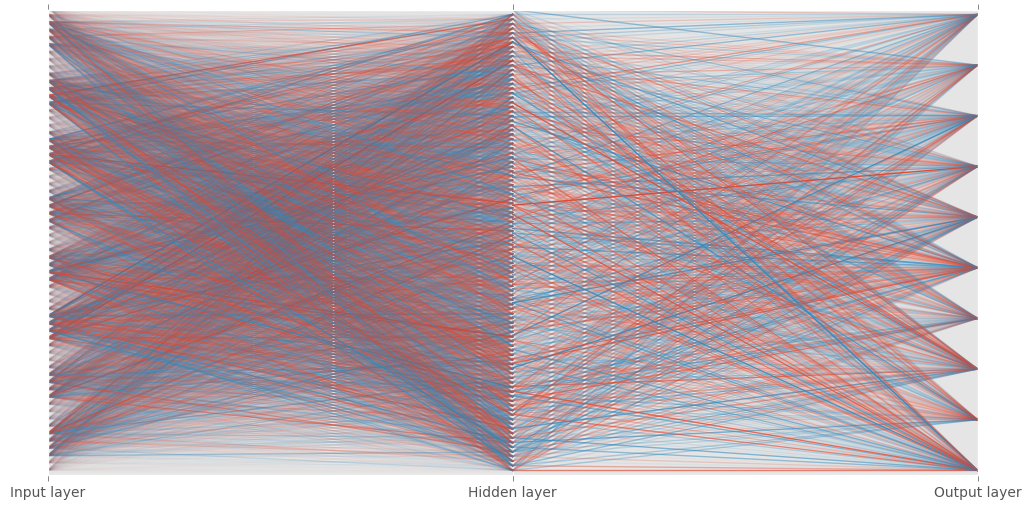

In [16]:
plt.figure(figsize=(12, 6))
connection_threads(net, stretch=True)